# Unsupervised ML with Penguins

The palmer penguin dataset is excellent for EDA and UML. It contains different measures for 3 species of closely related penguins from several islands in Antarctica.

Let's have a look:

Penguin datast: https://github.com/allisonhorst/palmerpenguins
![](https://github.com/allisonhorst/palmerpenguins/raw/master/man/figures/lter_penguins.png)

In [15]:
# Install umap for dimensionality reduction
!pip install umap-learn -q

     |████████████████████████████████| 88 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 16.5 MB/s 


In [1]:
# standard packaging

import pandas as pd
import seaborn as sns
sns.set(color_codes=True, rc={'figure.figsize':(10,8)})

from IPython.display import HTML #Youtube embed


In case you have a few minutes:

In [2]:
HTML('<iframe width="700" height="400" src="https://www.youtube-nocookie.com/embed/QS5jpQ6cpsg" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/usr/local/lib/python3.7/dist-packages/IPython/core/display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [3]:
# load the dataset from GitHub - original source

penguins = pd.read_csv("https://github.com/allisonhorst/palmerpenguins/raw/5b5891f01b52ae26ad8cb9755ec93672f49328a8/data/penguins_size.csv")

In [4]:
# Check the data

penguins.head()

,species_short,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [5]:
# drop all missing observations and count up the birds for each species

penguins = penguins.dropna()
penguins.species_short.value_counts()

Adelie       146
Gentoo       120
Chinstrap     68
Name: species_short, dtype: int64

![](https://github.com/allisonhorst/palmerpenguins/raw/master/man/figures/culmen_depth.png)


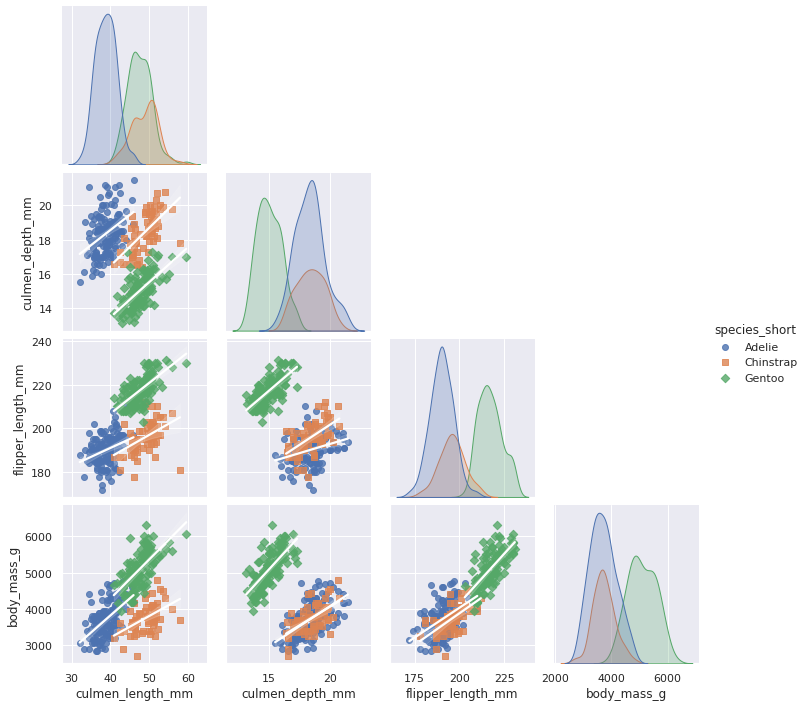

In [6]:
# Let's check out the data visually

sns.pairplot(penguins, hue='species_short', kind="reg", corner=True, markers=["o", "s", "D"], plot_kws={'line_kws':{'color':'white'}})

Overall we can see some general tendencies in the data:



*   Being "bio" data, it is rather normally distributed
*   Gentoos are on average heavier
*   Glipper length is correlated with body mass for all species
*   Culmen length and depth is correlated with body mass for gentoos but not so much for the other species (visual analysis...no proper calculation)
*   Overall there is obviousely some correlation between the variables that can be 'exploited' for dimensionality reduction.


Before we can do any machine learning, it is a good idea to scale the data. Most algorithms are not agnostic to magnitudes and bringing all variables on the same scale is therefore crucial.


In [7]:
# We load up Standard Scaler from sklearn

from sklearn.preprocessing import StandardScaler

In [8]:
# And scale all relevant variables into a new matrix (numpy)

scaled_penguins = StandardScaler().fit_transform(penguins.loc[:,'culmen_length_mm':'body_mass_g'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

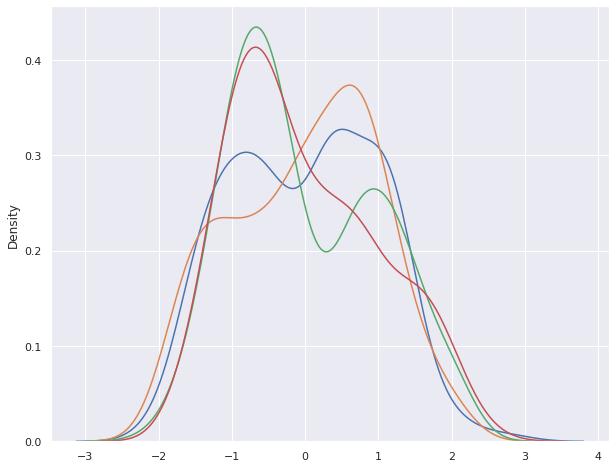

In [9]:
# all variables now have a mean of 0 and std of 1
for i in range(4):
  sns.distplot(scaled_penguins[:,i], hist=False)

## Econometrics detour
Python is not known for that but Statsmodels has in the past few years become a decent package for econometrics.
Let's see if we can quickly put a model to estimate the relationship most variables and DV culmen lenght.


In [25]:
import statsmodels.api as sm
from patsy import dmatrices

In [45]:
y, X = dmatrices('culmen_length_mm ~ culmen_depth_mm + flipper_length_mm + body_mass_g', data=penguins, return_type='dataframe')

In [46]:
X.head()

,Intercept,culmen_depth_mm,flipper_length_mm,body_mass_g
0,1.0,18.7,181.0,3750.0
1,1.0,17.4,186.0,3800.0
2,1.0,18.0,195.0,3250.0
4,1.0,19.3,193.0,3450.0
5,1.0,20.6,190.0,3650.0


In [47]:
mod = sm.OLS(y, X) # Describe model

In [48]:
res = mod.fit() # Fit model

In [49]:
print(res.summary())   # Summarize model

                            OLS Regression Results                            
Dep. Variable:       culmen_length_mm   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     93.40
Date:                Sat, 20 Aug 2022   Prob (F-statistic):           8.84e-44
Time:                        13:16:19   Log-Likelihood:                -937.75
No. Observations:                 334   AIC:                             1884.
Df Residuals:                     330   BIC:                             1899.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -25.5118      6.70

## Back to UML, dimensionality reduction and clustering

In [10]:
# Let's import PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # we explicitly ask for 2 components

In [11]:
# And now we use PCA to transform the data
pca_penguins = pca.fit_transform(scaled_penguins)

In [12]:
pca_penguins.shape # 334 rows, 2 columns - just as we wanted

(334, 2)

The two components should now contains information that describes the data but where the information within the two should be maximally dissimilar. 
Since we now have 2 dimension describing each observation, we can plot them against each other in a scatterplot.

You want to learn more about PCA and the math behind it?
Check out the chapter in the book: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


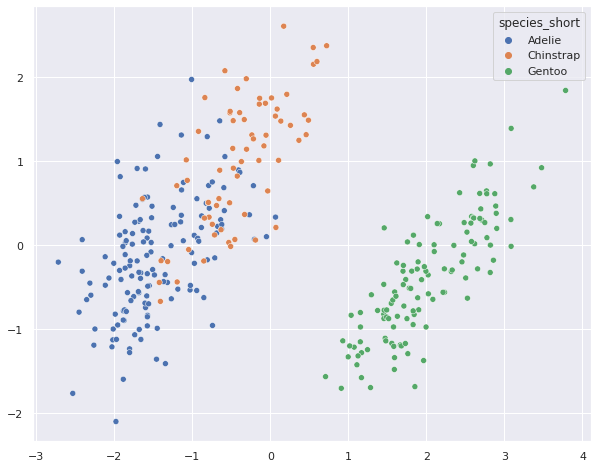

In [13]:
sns.scatterplot(pca_penguins[:,0], pca_penguins[:,1], hue = penguins['species_short'] )

# note that we are using numpy-indexing [:,0] means: all rows and only first column!!!

# we use the colors of the species that we know to see how well the PCA did...

Not too bad. We colo
Now let's try out UMAP, a new dimensionality reduction algorightm that comes with many interesting features: https://umap-learn.readthedocs.io/en/latest/

You want to learn more from the guy behind the algorithm?
https://youtu.be/nq6iPZVUxZU check out that excellent talk by Leland McInnes or https://arxiv.org/abs/1802.03426.



In [16]:
# Let's load umap and instantiate it 2-components is standard and we don't need to specify it

import umap
reducer = umap.UMAP()

In [17]:
# let's reduce the scalded data - same syntax as sklearn :-) 

umap_penguins = reducer.fit_transform(scaled_penguins)
umap_penguins.shape

(334, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


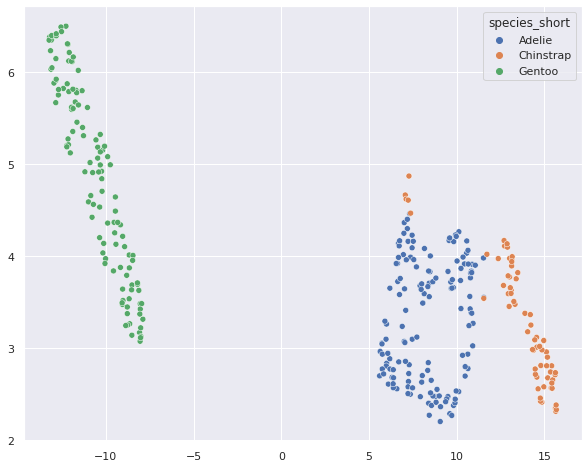

In [18]:
# Let's plot the matrix

sns.scatterplot(umap_penguins[:,0], umap_penguins[:,1], hue = penguins['species_short'] )

Umap seems to do a better job at reducing the dimensionality in a way that the resulting embedding fits well with the species destinction.

## Clustering

Now that we had a look at dimensionality reduction, let's see what clustering can do at the present case.

We will try out **K-means** and **hierarchical clustering**

In [19]:
# we import kmeans
from sklearn.cluster import KMeans

In [20]:
# and instantiate it where we need to specify that we want it to create 3 clusters

clusterer = KMeans(n_clusters=3)
clusterer.fit(scaled_penguins) #we only fit here, since no data needs to be transformed

KMeans(n_clusters=3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


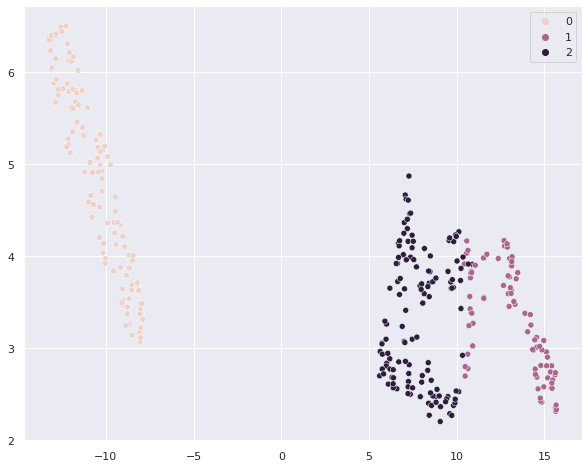

In [21]:
# now let's see how well the clusters fit with the species

sns.scatterplot(umap_penguins[:,0], umap_penguins[:,1], hue = clusterer.labels_ )

In [22]:
# we can check out a cross-tab with clusters vs. species
pd.crosstab(clusterer.labels_, penguins['species_short'])

species_short,Adelie,Chinstrap,Gentoo
row_0,,,
0,0,0,120
1,22,63,0
2,124,5,0


Now let's turn to hierarchical clustering - the procedure is the same, we just need to swap the algorithm name


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


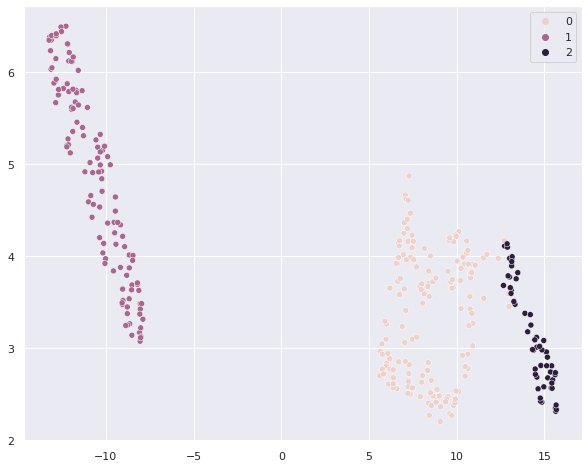

In [23]:
from sklearn.cluster import AgglomerativeClustering
clusterer = AgglomerativeClustering(n_clusters=3).fit(scaled_penguins)
sns.scatterplot(umap_penguins[:,0], umap_penguins[:,1], hue = clusterer.labels_ )

In [24]:
# Let's do the cross-tab with clusters vs. species
pd.crosstab(clusterer.labels_, penguins['species_short'])

species_short,Adelie,Chinstrap,Gentoo
row_0,,,
0,146,11,0
1,0,0,120
2,0,57,0
